In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages

# import inp_data_extractor.py as inp:
try:
    import inp_data_extractor as inp
except ImportError:
    try:
        from Bubble_dynamics_simulation import inp_data_extractor as inp
    except ImportError as error:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
        raise error
    except Exception as error:
        print(colored(f'Error, \'inp_data_extractor.py\' failed to load', 'red'))
        raise error
except Exception as error:
    print(colored(f'Error, \'inp_data_extractor.py\' failed to load', 'red'))
    raise error
importlib.reload(inp)   # reload changes you made

# create parameters.py
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files
from termcolor import colored   # for colored error messages

# import full_bubble_model.py as de:
_already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except ImportError:
    try:
        from  Bubble_dynamics_simulation import full_bubble_model as de
    except ImportError as _error:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
        raise _error
    except Exception as _error:
        print(colored(f'Error, \'full_bubble_model.py\' failed to load', 'red'))
        raise _error
except Exception as _error:
    print(colored(f'Error, \'full_bubble_model.py\' failed to load', 'red'))
    raise _error
if _already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [3]:
"""Base settings"""

# r-string will not convert \n to new line
directory = r'test_1atm_20000Hz_2D'
directory = os.path.abspath(directory)
file_base_name = 'output_'

In [4]:
"""Load all CSV files from directory into a dataframe (all_data)"""

# create a dataframe
all_data = pd.DataFrame()
num = 0
print(f'Found files:')

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))

        # Cast object-dtype columns with all-bool values to bool dtype
        for col in current_data.columns:
            if current_data[col].dtype == 'object' and all(current_data[col].dropna().map(lambda x: isinstance(x, bool))):
                current_data[col] = current_data[col].astype(bool)

        subdir = os.path.join(root.removeprefix(directory), file)
        print(f'\t{subdir: <64} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])
    
    
# Print some stats:
print(f'_______________________________________')
print(f'total number of files: {num}')
total = all_data.shape[0]
print(f'{"total:": <10} {total: < 8} rows   ( 100.00 %)')

# Print errors
def matches(error, error_code):
    errors, success = de.get_errors(error_code)
    return error in errors

for error in de.error_codes.keys():
    digit = -1; place = -1
    for i in range(10):
        if str(i) in error:
            digit = i
            place = len(error) - error.find(str(i)) - 1

    if digit < 0 and place < 0:
        print(colored(f'Error: invalid error code: {error}', 'red'))
        continue
    num = all_data.loc[(all_data['error_code'] // (10**place) % 10) == digit].shape[0]
    if error == 'x0x':
        num  -= all_data.loc[(all_data['error_code'] % 10) == 0].shape[0] # xx0
    print(f'{error + ":": <10} {num: < 8} rows   ({(100*num/total): 7.2f} %)\t' + colored(de.error_codes[error]['describtion'], de.error_codes[error]['color']))


energy_demand = 'energy_demand' if 'energy_demand' in all_data.columns else 'energy_efficiency' # compatibility with legacy code
print(f'_______________________________________')

Found files:
	output_1.csv                                                     (1001 rows)
	output_2.csv                                                     (1001 rows)
	output_3.csv                                                     ( 498 rows)
_______________________________________
total number of files: 3
total:      2500    rows   ( 100.00 %)
xx0:        2365    rows   (  94.60 %)	succecfully solved with LSODA solver
xx1:        54      rows   (   2.16 %)	LSODA solver didn't converge
xx2:        80      rows   (   3.20 %)	LSODA solver timed out
xx3:        1       rows   (   0.04 %)	LSODA solver had a fatal error
x0x:        59      rows   (   2.36 %)	succecfully solved with Radau solver
x4x:        60      rows   (   2.40 %)	Radau solver didn't converge (NO SOLUTION!)
x5x:        16      rows   (   0.64 %)	Radau solver timed out (NO SOLUTION!)
x6x:        0       rows   (   0.00 %)	Radau solver had a fatal error (NO SOLUTION!)
1xx:        0       rows   (   0.00 %)	Low pressure 

In [5]:
"""Locate valid (good_data) and wrong (wrong_data) simulations"""

# Get valid datas (or use all_data['success'] == True)
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data[energy_demand] > 0.0) & (all_data[energy_demand] == all_data[energy_demand]) # positive not NaN
    # or set negative energy to inf: good_data.loc[good_data['energy'] < 0.0, 'energy'] = 1e10
]

# Everything that's not in good_data
wrong_data = pd.concat([good_data, all_data]).drop_duplicates(keep=False)

# Sort by energy
good_data = good_data.sort_values([energy_demand], ascending=True)

# New column
good_data['logE'] = np.log10(good_data[energy_demand])
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

Good data: 2424 rows ( 96.96 %)


In [6]:
"""Let's see the dataframe"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'elapsed_time', 'steps', f'n_{de.target_specie}', energy_demand] + de.excitation_args]

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,elapsed_time,steps,n_NH3,energy_demand,p_A,freq,n
18,1029,0.000054,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.901307,12911,3.649780e-13,9.127176e+02,-214285.714286,20000.0,1.0
68,1080,0.000056,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.294051,12791,3.947137e-13,9.134600e+02,-218367.346939,20000.0,1.0
971,978,0.000052,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.755826,12229,3.346305e-13,9.172439e+02,-210204.081633,20000.0,1.0
144,1132,0.000059,1.0,101325.0,0.35,293.15,2338.339978,0.001018,6.142903,13203,4.538287e-13,9.172916e+02,-226530.612245,20000.0,1.0
124,1131,0.000059,1.0,101325.0,0.35,293.15,2338.339978,0.001018,2.345279,13357,4.232334e-13,9.194813e+02,-222448.979592,20000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,1702,0.000088,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.103867,6423,-6.091368e-38,1.000000e+30,-104081.632653,20000.0,1.0
302,2309,0.000118,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.352451,8554,-1.623655e-27,1.000000e+30,-132653.061224,20000.0,1.0
451,2457,0.000125,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.561763,8292,2.102518e-40,1.407772e+30,-124489.795918,20000.0,1.0
51,2054,0.000105,1.0,101325.0,0.35,293.15,2338.339978,0.001018,1.549289,7311,2.336280e-41,6.812010e+30,-112244.897959,20000.0,1.0


In [7]:
"""Print some statistics"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'elapsed_time', 'steps', f'n_{de.target_specie}', energy_demand] + de.excitation_args].describe()

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,elapsed_time,steps,n_NH3,energy_demand,p_A,freq,n
count,2424.000000,2424.000000,2424.0,2424.0,2.424000e+03,2.424000e+03,2424.000000,2.424000e+03,2424.000000,2424.000000,2.424000e+03,2.424000e+03,2424.000000,2424.0,2424.0
mean,1271.895215,0.000066,1.0,101325.0,3.500000e-01,2.931500e+02,2338.339978,1.017649e-03,3.467754,13595.968647,1.008249e-13,1.456158e+29,-198420.556341,20000.0,1.0
std,718.334798,0.000035,0.0,0.0,5.552261e-17,5.685515e-14,0.000000,2.168852e-19,7.712906,3895.831704,1.940290e-13,2.920548e+30,58835.827087,0.0,0.0
min,1.000000,0.000005,1.0,101325.0,3.500000e-01,2.931500e+02,2338.339978,1.017649e-03,0.404492,5969.000000,-1.845499e-18,9.127176e+02,-300000.000000,20000.0,1.0
25%,648.750000,0.000034,1.0,101325.0,3.500000e-01,2.931500e+02,2338.339978,1.017649e-03,1.399595,11878.000000,2.497769e-19,3.589665e+03,-251020.408163,20000.0,1.0
50%,1282.500000,0.000066,1.0,101325.0,3.500000e-01,2.931500e+02,2338.339978,1.017649e-03,2.019503,13742.000000,5.836254e-15,5.214213e+04,-197959.183673,20000.0,1.0
75%,1894.250000,0.000096,1.0,101325.0,3.500000e-01,2.931500e+02,2338.339978,1.017649e-03,3.100396,15176.000000,9.818987e-14,5.648354e+08,-148979.591837,20000.0,1.0
max,2500.000000,0.000125,1.0,101325.0,3.500000e-01,2.931500e+02,2338.339978,1.017649e-03,127.160641,92390.000000,1.047483e-12,1.430721e+32,-100000.000000,20000.0,1.0


succecfully solved with LSODA solver


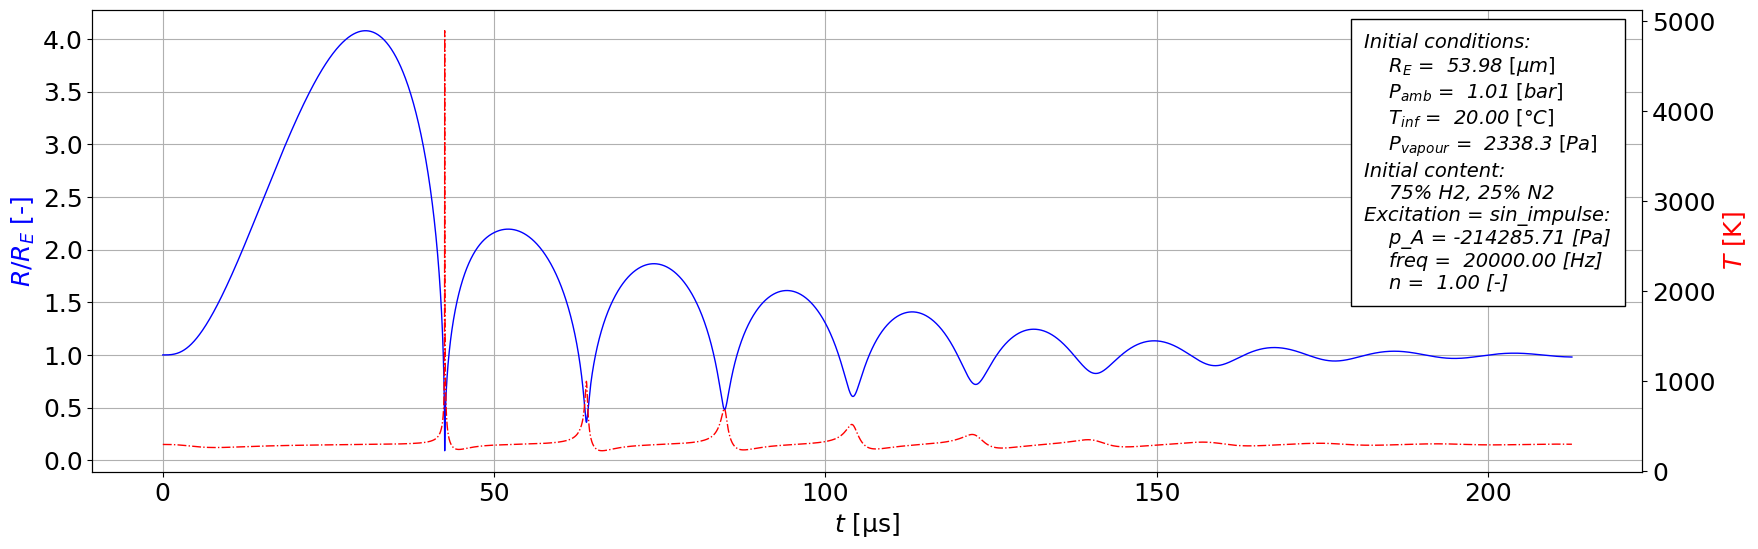

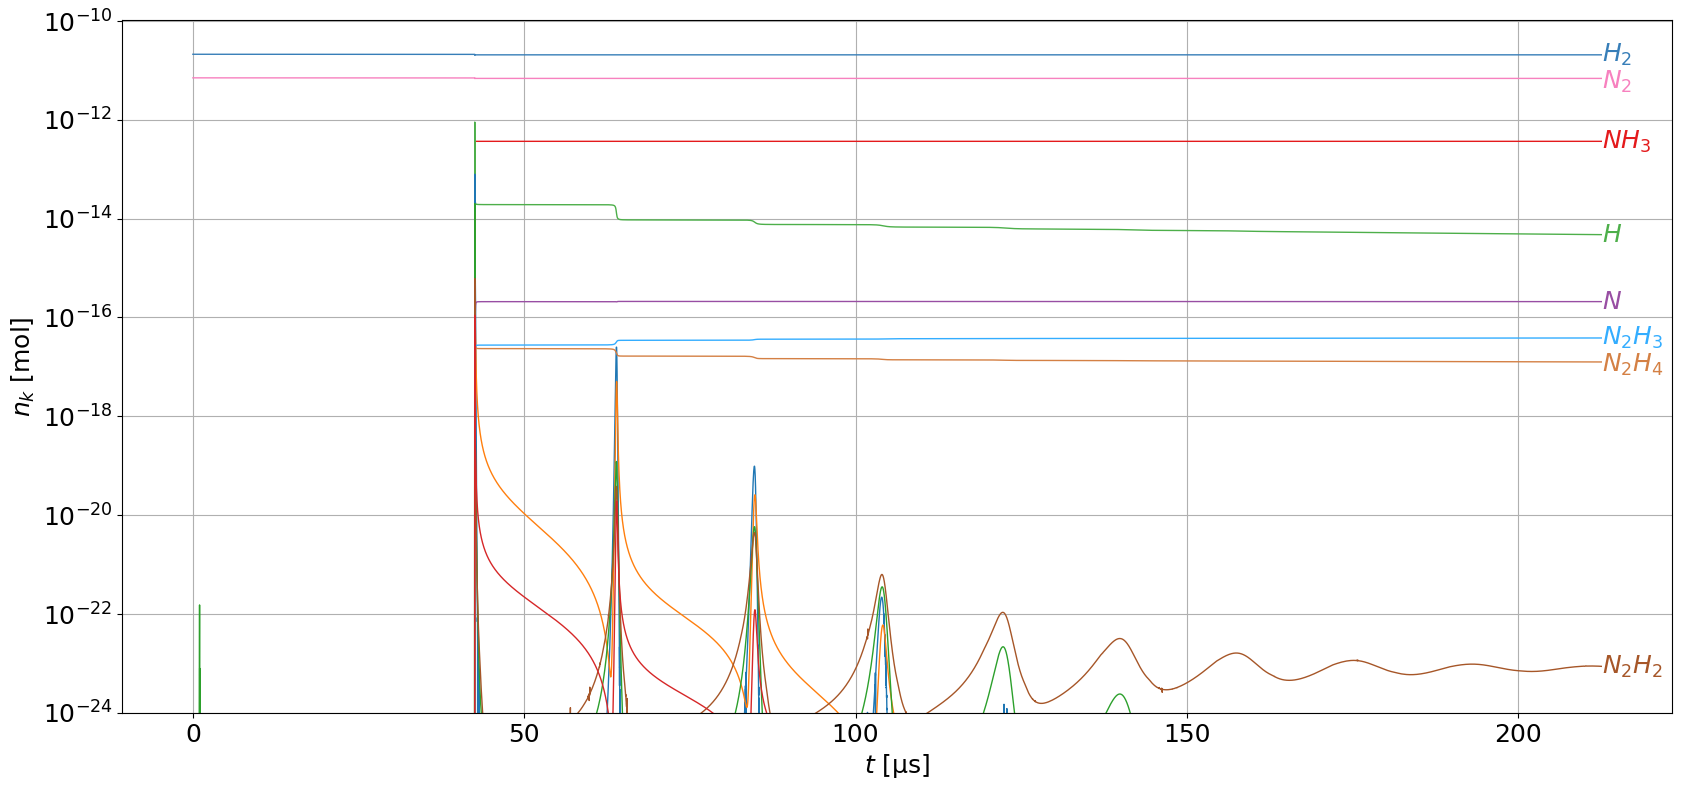

Control parameters:
    ID = 1029,                                   # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  0.00005398,                           # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['H2'], par.index['N2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.75, 0.25],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  101325.00,                          # ambient pressure [Pa]
    T_inf =  293.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.3500,                            # water accommodation coefficient [-]
    P_v =  2338.34,                              # vapour pressure [Pa]
    mu_L =  0.0010,                              # dynamic viscosity [Pa*

In [8]:
"""Plot a certain simulation"""

# converts a line of all_data to a dictionary containing the control parameters (cpar)
def line_to_dict(line):
    # check 'full_bubble_model.py' settings
    if (de.enable_heat_transfer != line['enable_heat_transfer'] or
        de.enable_evaporation != line['enable_evaporation'] or
        de.enable_reactions != line['enable_reactions'] or
        de.enable_dissipated_energy != line['enable_dissipated_energy'] or
        de.target_specie != line['target_specie'] or
        de.excitation_type != line['excitation_type']):
        print(colored(f'Error: the settings of \'full_bubble_model.py\' do not match the current settings', 'red'))

    gases = str(line['gases'])
    gases = [int(index) for index in gases.split(' ') if index != '']
    fractions = str(line['fractions'])
    fractions = [float(frac) for frac in fractions.split(' ') if frac != '']

    cpar = de.dotdict(dict(
        ID = line['ID'],                  # ID of control parameter (not used during calculation)
    # Initial conditions:
        R_E = line['R_E'],                # bubble equilibrium radius [m]
        ratio = line['ratio'],            # initial radius / equilibrium radius R_0/R_E [-]
        gases = gases,                    # indexes of species in initial bubble (list of species indexes)
        fractions = fractions,            # molar fractions of species in initial bubble (list of fractions for every gas)
    # Ambient parameters:
        P_amb = line['P_amb'],            # ambient pressure [Pa]
        T_inf = line['T_inf'],            # ambient temperature [K]
    # Liquid parameters:
        alfa_M = line['alfa_M'],          # water accommodation coefficient [-]
        P_v = line['P_v'],                # vapour pressure [Pa]
        rho_L = line['rho_L'] if 'rho_L' in line else par.rho_L, # density [kg/m^3]
        mu_L = line['mu_L'],              # dynamic viscosity [Pa*s]
        c_L = line['c_L'],                # sound speed [m/s]
        surfactant = line['surfactant'],  # surfactant (surface tension modfier) [-]
    ))

    # Excitation parameters:
    for arg in de.excitation_args:
        cpar[arg] = line[arg]

    return cpar

cpar = line_to_dict(good_data.iloc[0])   # choose the most energy efficient one
de.plot(cpar, t_int=[0.0, 1.0], n=5.0, base_name='', format='png', LSODA_timeout=30.0, Radau_timeout=300.0,
        presentation_mode=False, plot_pressure=False, plot_extra=False, show_legend=False, show_cpar=True)